# 작사가 제일 쉬웠어요!

NLP를 통해 멋진 가사를 만들어내는 작사가 모델을 만들어보자.

## 1. 필요한 모듈 import

In [2]:
import re
import numpy as np
import tensorflow as tf
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. 데이터 로드 및 개수 확인

In [3]:
# 문장의 총 개수 구하기

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = [] # 문장들이 담길 list

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['At first I was afraid', 'I was petrified', 'I kept thinking I could never live without you']


## 3. 데이터 전처리

문장을 학습시키기 쉽게 불필요한 부분은 제거하고, 하나의 기준으로 문장을 정리한다.
1. 소문자로 변환한 후 양쪽 공백을 지운다.
2. 문장에 포함된 특수문자 양쪽에 공백 추가(split하기 위해)
3. 문장 내의 2개 이상인 공백을 1개의 공백으로 변환한다.
4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾼다.
5. 양쪽 공백을 지운다.
6. 모든 전처리가 끝난 문장 앞뒤로 \<start\>와 \<end\>를 붙인다. (토큰화)
    


In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    # 문자열 앞에 r이 붙으면 해당 문자열이 구성된 그대로 문자열 반환 예를 들어 \n 같은 경우에도 raw string으로 그대로 출력
    # \1은 재참조 메타 문자.
    
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence(raw_corpus[0]))

<start> at first i was afraid <end>


* 길이가 0인 문장을 제거한다.
* 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거한다.

In [5]:
# 여기에 정제된 문장을 모을 리스트 생성
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뛴다.
    # 길이가 0이거나 단어의 개수가 15개 이상인 문장을 건너뛴다.
    # <start>와 <end>를 제외해야 하므로 13개 
    if len(sentence) == 0 : continue
    
    # 정제를 하고 담는다.
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15 : continue
    
    corpus.append(preprocessed_sentence)
    
len_list = []
for s in corpus:
    len_list.append(len(s.split()))
    
# 정제된 결과를 30개 확인
print(len(corpus))

corpus[:30]

156227


['<start> at first i was afraid <end>',
 '<start> i was petrified <end>',
 '<start> i kept thinking i could never live without you <end>',
 '<start> by my side but then i spent so many nights <end>',
 '<start> just thinking how you ve done me wrong <end>',
 '<start> i grew strong <end>',
 '<start> i learned how to get along and so you re back <end>',
 '<start> from outer space <end>',
 '<start> i just walked in to find you <end>',
 '<start> i would have made you leave your key <end>',
 '<start> if i had known for just one second <end>',
 '<start> you d be back to bother me well now go , <end>',
 '<start> walk out the door <end>',
 '<start> just turn around <end>',
 '<start> now , you re not welcome anymore weren t you the one <end>',
 '<start> who tried to break me with desire ? <end>',
 '<start> did you think i d crumble ? <end>',
 '<start> i will survive <end>',
 '<start> yeah <end>',
 '<start> i ve got all my life to live <end>',
 '<start> i ve got all my love to give <end>',
 '<sta

* 그래프로 전처리 확인

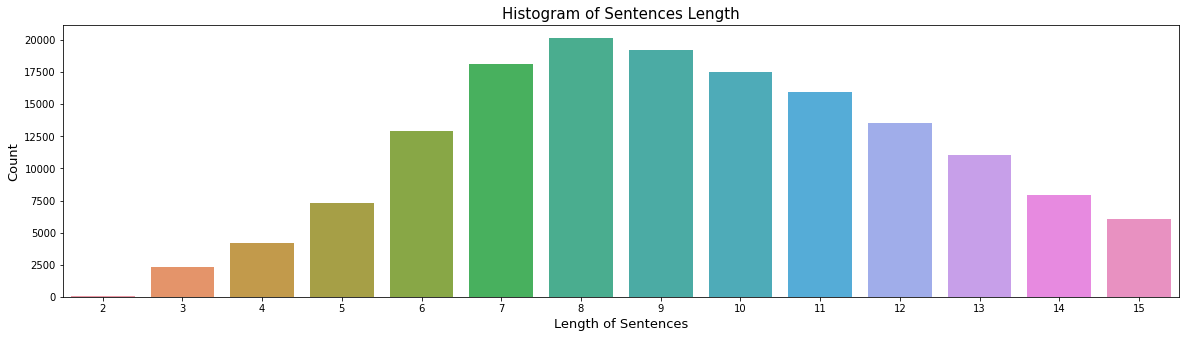

In [6]:
import collections

# collections.Counter로 len_list의 토큰 개수를 개수 별 딕셔너리 형태로 반환한다.
len_count = collections.Counter(len_list)

se = pd.Series(len_count)
se.sort_index(inplace=True)

plt.figure(figsize=(20,5))

sns.barplot(x=se.index, y=se.values)
plt.title('Histogram of Sentences Length', fontsize=15)
plt.xlabel('Length of Sentences', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.show()

## 4. 데이터 토큰화
수학적 연산을 위해 문자 데이터를 Tensor로 변환, tf.tokenizer()를 통해 편리하게 변환할 수 있다.

* 각 문자에 대응되는 숫자 사전을 만든다. (12000개)
* 사전에 포함되지 않은 단어는 ukn으로 대체한다.
* 문자를 단어별로 split한 후 각 문자에 대응하는 숫자로 변환한다.

In [7]:
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer
    # preprocessing을 통해 데이터 전처리를 완료했으므로 filter는 필요 없다.
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 대체한다.
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성한다.
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환한다.
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰준다.
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰준다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   70  247 ...    0    0    0]
 [   2    4   53 ...    0    0    0]
 [   2    4 1066 ...    0    0    0]
 ...
 [   2    8    4 ...    0    0    0]
 [   2   44   17 ...    0    0    0]
 [   2    6  174 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f56c2878050>


In [8]:
#단어사전 확인
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    
    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


## 5. 데이터셋 생성

Tensor에서 모델을 학습할 때 필요한 입력값(source)과 출력값(target)을 나눠 정리한다.

* 입력값(source) : \<start\>를 포함하고 맨 뒤 값인 \<end\>를 제외한 문장, 그러나 마지막 토큰은 \<end\>가 아닌 padding일 확률이 매우 높다.
* 출력값(target) : \<start\> 다음 단어부터 \<end\> 까지의 문장

In [9]:
#source, target 문장 생성
src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]

print(src_input[0])
print(tgt_input[0])
src_input.shape

[  2  70 247   4  53 708   3   0   0   0   0   0   0   0]
[ 70 247   4  53 708   3   0   0   0   0   0   0   0   0]


(156227, 14)

* Train set과 Validation set 8 : 2로 분리

In [10]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2)

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print("Source Validation:", enc_val.shape)
print("Target Validation:", dec_val.shape)

Source Train: (124981, 14)
Target Train: (124981, 14)
Source Validation: (31246, 14)
Target Validation: (31246, 14)


## 6. 모델 설계
#### 일반 LSTM 모델

가사 데이터를 통해 학습할 모델 정의

* Embedding Layer : Word2Vec 역할을 하는 Layer, 단어를 저차원의 실수형 밀집 벡터(Dense vector)로 만든다. 
* LSTM(Long Short-Term Memory) Layer : 은닉층의 메모리 셀에 입력 게이트, 망각 게이트, 출력 게이트를 추가해 불필요한 메모리를 지우고, 필요한 메모리를 저장한다.
* Dense Layer : Fully-Connected Layer로 출력값을 결정짓는다.

**Embedding(number of sample, embedding_size, input_length)**    
number of sample : 단어 집합의 크기. 즉, 총 단어의 개수  
embedding_size : 임베딩 벡터의 출력 차원. 결과로서 나오는 임베딩 벡터의 크기  
input_length : 입력 시퀀스의 길이  

In [11]:
vocab_size = tokenizer.num_words + 1  # 단어사전의 단어 개수 + 0:<pad>
embedding_size = 256
hidden_size = 1024

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_size))
model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=True))
model.add(tf.keras.layers.Dense(vocab_size))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         3072256   
_________________________________________________________________
lstm (LSTM)                  (None, None, 1024)        5246976   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 1024)        8392704   
_________________________________________________________________
dense (Dense)                (None, None, 12001)       12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


## 7. 모델 학습

In [12]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(enc_train, dec_train, epochs=10)

Epoch 1/10
3906/3906 [==============================] - 293s 74ms/step - loss: 3.3536
Epoch 2/10
3906/3906 [==============================] - 293s 75ms/step - loss: 2.6685
Epoch 3/10
3906/3906 [==============================] - 295s 75ms/step - loss: 2.3586
Epoch 4/10
3906/3906 [==============================] - 296s 76ms/step - loss: 2.0825
Epoch 5/10
3906/3906 [==============================] - 296s 76ms/step - loss: 1.8386
Epoch 6/10
3906/3906 [==============================] - 296s 76ms/step - loss: 1.6409
Epoch 7/10
3906/3906 [==============================] - 296s 76ms/step - loss: 1.4766
Epoch 8/10
3906/3906 [==============================] - 296s 76ms/step - loss: 1.3450
Epoch 9/10
3906/3906 [==============================] - 298s 76ms/step - loss: 1.2406
Epoch 10/10
3906/3906 [==============================] - 298s 76ms/step - loss: 1.1620


## 8. 문장 생성하기
위에서 학습한 모델을 통해 문장을 생성한다.

In [17]:
# 문장 생성 함수
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환한다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 한다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력한다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 된다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 준다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 한다..
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환한다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

#### 'i love' 입력

In [18]:
# 문장 생성 함수 실행하여 모델에게 작문 시켜보기
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you so , <end> '

#### 'when i was' 입력

In [20]:
generate_text(model, tokenizer, init_sentence="<start> when i was", max_len=20)

'<start> when i was shot dat nixga like i started to <end> '

#### 'what would you' 입력

In [21]:
generate_text(model, tokenizer, init_sentence="<start> what would you", max_len=20)

'<start> what would you do ? <end> '

#### 'he was a' 입력

In [22]:
generate_text(model, tokenizer, init_sentence="<start> he was a", max_len=20)

'<start> he was a very much <end> '

#### 'happy' 입력

In [23]:
generate_text(model, tokenizer, init_sentence="<start> happy", max_len=20)

'<start> happy birthday , happy birthday , happy birthday woo , shake ! <end> '

#### 'i am' 입력

In [24]:
generate_text(model, tokenizer, init_sentence="<start> i am", max_len=20)

'<start> i am a god <end> '

#### 'i m' 입력

In [26]:
generate_text(model, tokenizer, init_sentence="<start> i m", max_len=20)

'<start> i m the one <end> '

## 결론 및 고찰
* 학습하는데 많은 시간이 소요되었지만 loss 1.16정도로 낮은 loss를 얻을 수 있었다.
* 생성한 문장 중 'when i was' 로 시작하는 문장은 의미를 알 수 없는 문장을 생성해냈다. 해당 문장으로 시작하는 데이터의 경우 학습 데이터가 부족하다면 의미를 알 수 없는 문장을 생성해 낼 수도 있다는 것을 알 수 있었다.
* 'i am'과 'i m'이 다른 문장을 생성하는 것을 볼 때 축소된 단어는 다른 단어로 인식하고 있으며, 같은 단어로 인식하게 만들 수 있으면 더 좋은 성능을 낼 수 있을 것이라고 생각한다.
* 결론적으로 아주 만족스러운 모델이 만들어졌다고는 생각되지 않는다. 하지만 전처리 과정에서 각 단어들의 특성을 조금 더 반영하고, 더 많은 데이터를 확보해 학습한다면 정말 좋은 가사들을 많이 만들어 낼 수 있을 것 같다.